In [1]:
!python --version

Python 3.8.5


# Data prepration

In [3]:
import numpy as np
import datetime
import os
import sklearn.metrics
import matplotlib.pyplot as plt

In [4]:
y = np.random.binomial(1,0.5,100000)
x = np.c_[np.random.normal(y,0.8),np.random.normal(-y,0.8)]

In [5]:
x.shape, y.shape

((100000, 2), (100000,))

In [6]:
ntrain = 80000
x_train, x_test = x[:ntrain], x[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]

# Keras

In [7]:
import tensorflow as tf

In [8]:
tf.__version__

'2.4.1'

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model(x_train[:3,])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.4851246 ],
       [0.4789807 ],
       [0.46782014]], dtype=float32)>

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (3, 128)                  384       
_________________________________________________________________
dropout (Dropout)            (3, 128)                  0         
_________________________________________________________________
dense_1 (Dense)              (3, 128)                  16512     
_________________________________________________________________
dense_2 (Dense)              (3, 1)                    129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


In [12]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [13]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [14]:
batch_size = 1000

checkpoint_path = "tutorial/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=10*batch_size
)

In [15]:
log_dir = "tutorial/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
EPOCHS=10

In [17]:
model.fit(
    x_train, y_train, epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/10
80/80 [==============================] - 22s 236ms/step - loss: 0.5322 - accuracy: 0.7438
Epoch 2/10
80/80 [==============================] - 5s 59ms/step - loss: 0.4104 - accuracy: 0.8112
Epoch 3/10
80/80 [==============================] - 2s 27ms/step - loss: 0.4134 - accuracy: 0.8095
Epoch 4/10
80/80 [==============================] - 1s 9ms/step - loss: 0.4109 - accuracy: 0.8093
Epoch 5/10
80/80 [==============================] - 1s 11ms/step - loss: 0.4120 - accuracy: 0.8091
Epoch 6/10
80/80 [==============================] - 2s 20ms/step - loss: 0.4108 - accuracy: 0.8108
Epoch 7/10
80/80 [==============================] - 1s 10ms/step - loss: 0.4146 - accuracy: 0.8086
Epoch 8/10
80/80 [==============================] - 1s 8ms/step - loss: 0.4107 - accuracy: 0.8080
Epoch 9/10
80/80 [==============================] - 1s 7ms/step - loss: 0.4070 - accuracy: 0.8120
Epoch 10/10
80/80 [==============================] - 1s 9ms/step - loss: 0.4111 - accuracy: 0.8086


In [20]:
model.evaluate(x_test,  y_test, verbose=2)

625/625 - 0s - loss: 0.4161 - accuracy: 0.8083


[0.4161326289176941, 0.8083000183105469]

In [22]:
print("predictions:", model(x_test[:3,]).numpy()[:, 0])
print("Truths:",y_test[:3])

predictions: [0.23121822 0.18124333 0.9861289 ]
Truths: [1 0 1]


In [23]:
predictions, y_true = model(x_test).numpy()[:, 0], y_test > 0.5

In [35]:
y_true

array([ True, False,  True, ..., False, False,  True])

Text(0.5, 0, 'Score')

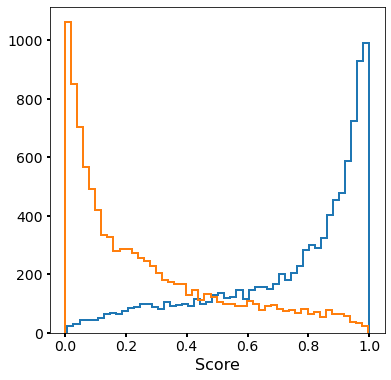

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(predictions[y_true], histtype='step', lw=2, bins=50)
ax.hist(predictions[~y_true],histtype='step', lw=2, bins=50)
ax.set_xlabel("Score")

In [27]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, predictions)

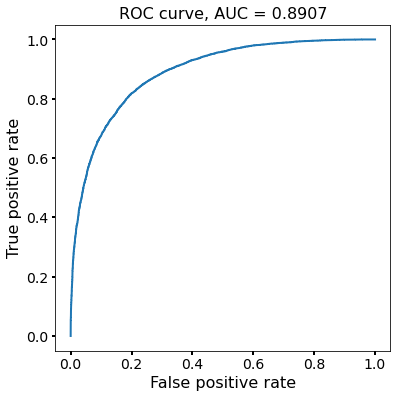

In [30]:
fontsize=16
minor_size=14
fig, ax1 = plt.subplots(figsize=(6,6))
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=2)
# ax1.plot([0, 1], [0, 1], '--', lw=2)
ax1.set_xlabel('False positive rate', fontsize=fontsize)
ax1.set_ylabel('True positive rate', fontsize=fontsize)
ax1.set_title('ROC curve, AUC = %.4f' % auc, fontsize=fontsize)
ax1.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)

In [46]:
!pwd

/global/cfs/cdirs/atlas/xju/software/root_gnn/notebook


# Customized Keras in TF

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(60000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [50]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999
)


In [56]:
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_fn(y_train, predictions)
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [57]:
for epoch in range(EPOCHS):
    for (x_train, y_train) in train_dataset:
        train_step(model, optimizer, x_train, y_train)

In [59]:
print("predictions:", model(x_test[:3,]).numpy()[:, 0])
print("Truths:",y_test[:3])

predictions: [0.7311755 0.224255  0.9413891]
Truths: [1 1 1]
